Building Custom VIT

In [1]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00


In [2]:
!pip -q install vit_pytorch linformer

In [3]:
from __future__ import print_function
import numpy as np
import pandas as pd
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [4]:
batch_size = 128
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [6]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.2


In [7]:
from torchvision.datasets import CIFAR10
import torchvision

100%|██████████| 170498071/170498071 [00:04<00:00, 35027759.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


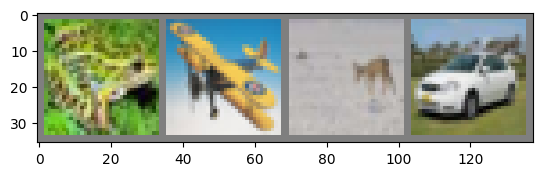

 frog plane  deer   car


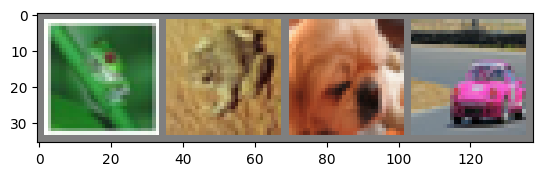

 frog  frog   dog   car


In [8]:
torch.manual_seed(42)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Show a few images from the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show training images
trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Show testing images
testloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
images, labels = next(iter(testloader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Function to return image and label of training and testing dataset
def get_image_and_label(dataset, index):
    image, label = dataset[index]
    return image, label

# Split dataset into train and test
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define dataloaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,
    depth=12,
    heads=8,
    k=64
)

In [10]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [11]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [12]:
epochs =  10
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.9268 - acc: 0.2906 - val_loss : 1.7267 - val_acc: 0.3749



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.6179 - acc: 0.4243 - val_loss : 1.5732 - val_acc: 0.4418



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.4909 - acc: 0.4696 - val_loss : 1.4916 - val_acc: 0.4674



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.4003 - acc: 0.5024 - val_loss : 1.4527 - val_acc: 0.4816



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.3226 - acc: 0.5275 - val_loss : 1.4035 - val_acc: 0.5008



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.2530 - acc: 0.5546 - val_loss : 1.4034 - val_acc: 0.5047



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.1895 - acc: 0.5757 - val_loss : 1.3807 - val_acc: 0.5142



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.1255 - acc: 0.6022 - val_loss : 1.3791 - val_acc: 0.5176



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.0634 - acc: 0.6253 - val_loss : 1.3891 - val_acc: 0.5211



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.0012 - acc: 0.6449 - val_loss : 1.4240 - val_acc: 0.5213



In [13]:
# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f"Accuracy on test set: {correct/total * 100:.2f}%")

Accuracy on test set: 51.76%


In [14]:
from sklearn.metrics import confusion_matrix
import torch
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)

    # Append true labels and predicted labels to the lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Print confusion matrix with labels
print(classes)
print("Confusion Matrix:")
print("\t" + "\t".join(str(label) for label in class_labels))
for i, row in enumerate(conf_matrix):
    print(f"{class_labels[i]}\t" + "\t".join(str(count) for count in row))

# Print the confusion matrix
print("Confusion Matrix:")


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Confusion Matrix:
	0	1	2	3	4	5	6	7	8	9
0	648	62	36	9	36	10	23	27	91	58
1	48	676	7	13	24	7	14	18	69	124
2	109	20	314	70	187	89	89	71	27	24
3	40	32	52	269	100	239	124	67	32	45
4	67	12	73	38	514	53	101	91	30	21
5	25	17	54	167	112	417	78	66	24	40
6	14	23	42	61	125	49	614	19	20	33
7	62	17	33	48	135	76	26	539	14	50
8	121	84	7	13	31	13	7	11	651	62
9	54	242	10	28	22	16	17	27	50	534
Confusion Matrix:


In [15]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       plane       0.55      0.65      0.59      1000
         car       0.57      0.68      0.62      1000
        bird       0.50      0.31      0.39      1000
         cat       0.38      0.27      0.31      1000
        deer       0.40      0.51      0.45      1000
         dog       0.43      0.42      0.42      1000
        frog       0.56      0.61      0.59      1000
       horse       0.58      0.54      0.56      1000
        ship       0.65      0.65      0.65      1000
       truck       0.54      0.53      0.54      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



In [16]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters in the ViT model: {total_params}")

Total parameters in the ViT model: 2859274


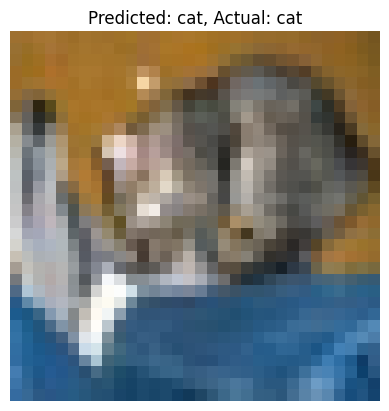

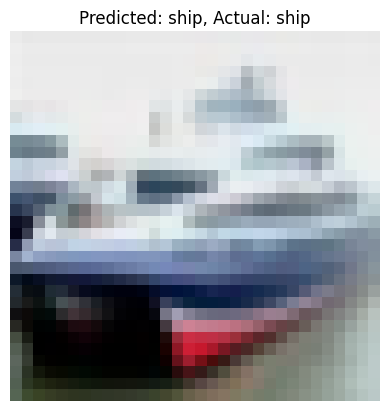

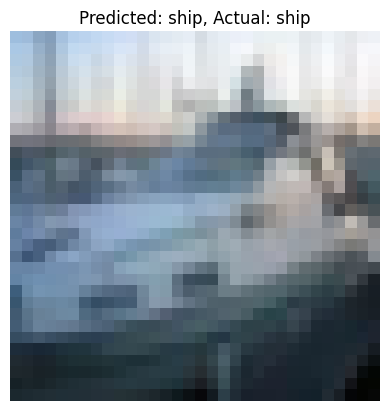

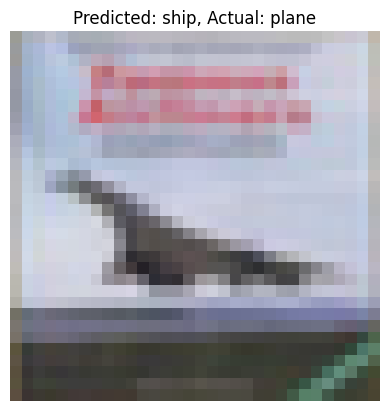

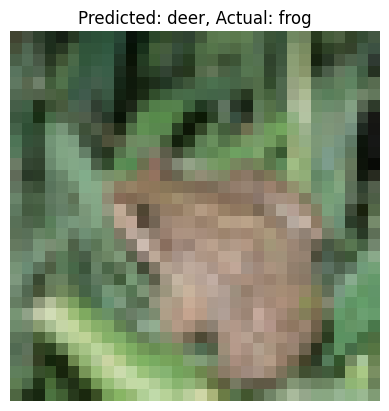

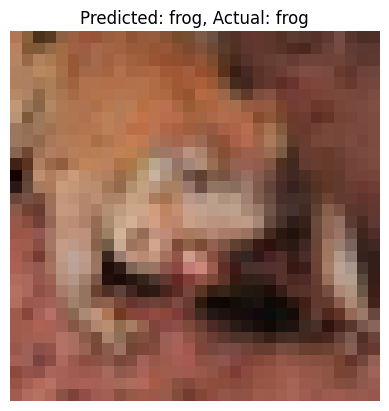

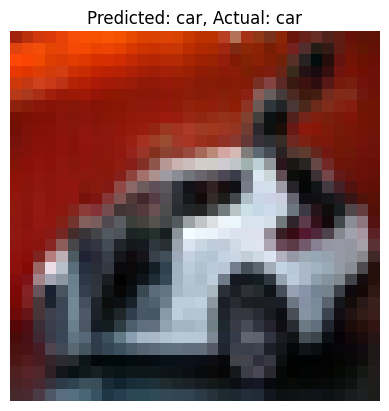

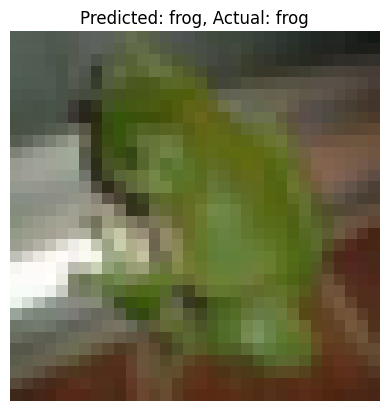

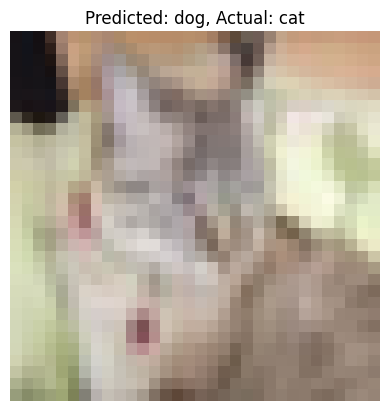

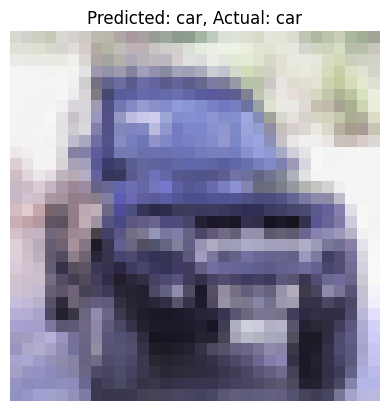

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Set the model to evaluation mode
model.eval()

# Transform to unnormalize images
unnormalize = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1.0 / 0.5, 1.0 / 0.5, 1.0 / 0.5))

# Iterate over the test dataset and make predictions
for data, labels in test_loader:
    data = data.to(device)

    # Forward pass
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)

    # Unnormalize and print images with predicted labels
    for i in range(10):
        image = unnormalize(data[i]).permute(1, 2, 0).cpu().numpy()
        plt.imshow(image)
        plt.title(f"Predicted: {classes[predicted[i].item()]}, Actual: {classes[labels[i].item()]}")
        plt.axis('off')
        plt.show()



    break  # Break after the first batch to visualize images


Import all the necessary libraries for pre trained vision transformers

In [18]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [19]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from timm.models.vision_transformer import VisionTransformer
import timm




Here, we used "vit_small_patch16_224" pre-trained model and applied transfer learning .

In [20]:
class VisionTransformerModel(nn.Module):
    def __init__(self, num_classes=10, image_size=224, patch_size=16, hidden_dim=384, num_heads=6, num_layers=6, dropout=0.1):
        super(VisionTransformerModel, self).__init__()
        self.model = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)



Files already downloaded and verified
Files already downloaded and verified


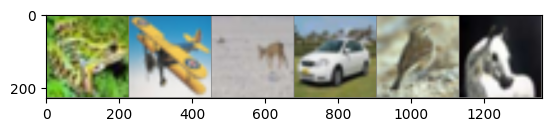

 frog airplane  deer automobile  bird horse


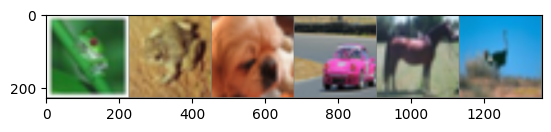

 frog  frog   dog automobile horse  bird


In [21]:
torch.manual_seed(42)
# Modify the transform to resize images to 224x224 pixels
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Show a few images from the dataset
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show training images
trainloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))

# Show testing images
testloader = DataLoader(test_dataset, batch_size=6, shuffle=True)
images, labels = next(iter(testloader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))

# Function to return image and label of training and testing dataset
def get_image_and_label(dataset, index):
    image, label = dataset[index]
    return image, label




In [22]:

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define dataloaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



In [23]:
model = VisionTransformerModel(num_classes=10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

VisionTransformerModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approxima

In [24]:

epochs = 3
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████| 313/313 [03:37<00:00,  1.44it/s]


Epoch : 1 - loss : 0.2090 - acc: 0.9302 - val_loss : 0.1712 - val_acc: 0.9421



100%|██████████| 313/313 [03:36<00:00,  1.45it/s]


Epoch : 2 - loss : 0.1169 - acc: 0.9611 - val_loss : 0.1805 - val_acc: 0.9408



100%|██████████| 313/313 [03:36<00:00,  1.45it/s]


Epoch : 3 - loss : 0.0928 - acc: 0.9687 - val_loss : 0.1693 - val_acc: 0.9452



In [25]:
# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f"Accuracy on test set: {correct/total * 100:.2f}%")

Accuracy on test set: 94.52%


In [26]:
from sklearn.metrics import confusion_matrix
import torch
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)

    # Append true labels and predicted labels to the lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Print confusion matrix with labels
print(classes)
print("Confusion Matrix:")
print("\t" + "\t".join(str(label) for label in class_labels))
for i, row in enumerate(conf_matrix):
    print(f"{class_labels[i]}\t" + "\t".join(str(count) for count in row))

# Print the confusion matrix
print("Confusion Matrix:")



('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Confusion Matrix:
	0	1	2	3	4	5	6	7	8	9
0	945	2	1	8	1	0	0	0	41	2
1	1	975	0	0	0	0	0	0	2	22
2	24	1	891	32	21	19	3	1	5	3
3	1	1	1	930	23	33	3	1	4	3
4	5	0	1	4	982	4	1	3	0	0
5	0	0	0	79	13	903	0	4	0	1
6	4	0	2	39	15	3	935	0	2	0
7	4	0	4	10	21	21	2	938	0	0
8	6	2	0	1	0	0	0	1	988	2
9	2	23	0	3	0	0	0	0	7	965
Confusion Matrix:


In [27]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.95      0.94      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.99      0.89      0.94      1000
         cat       0.84      0.93      0.88      1000
        deer       0.91      0.98      0.95      1000
         dog       0.92      0.90      0.91      1000
        frog       0.99      0.94      0.96      1000
       horse       0.99      0.94      0.96      1000
        ship       0.94      0.99      0.96      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [28]:
print(classes)

('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


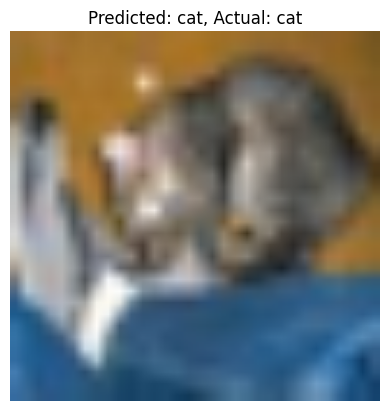

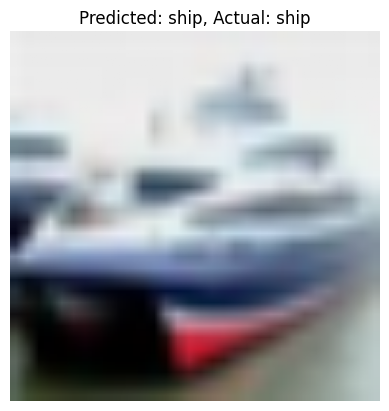

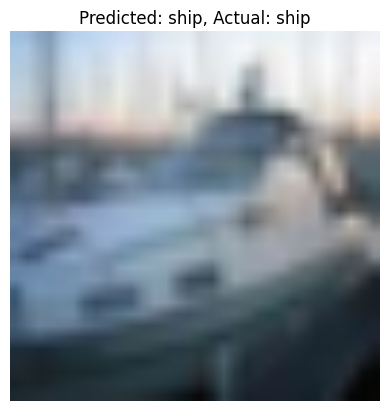

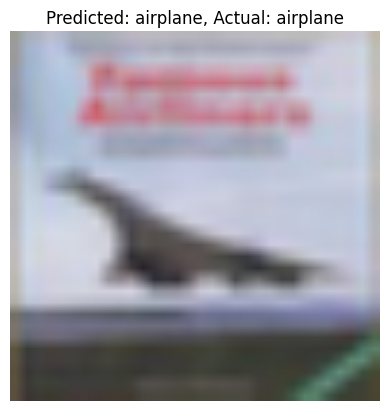

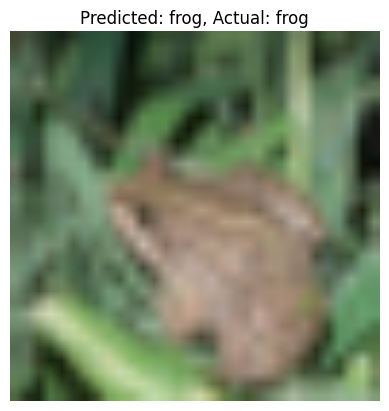

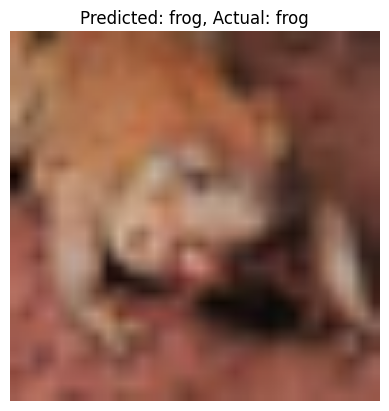

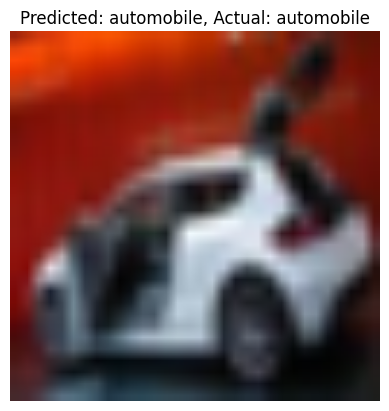

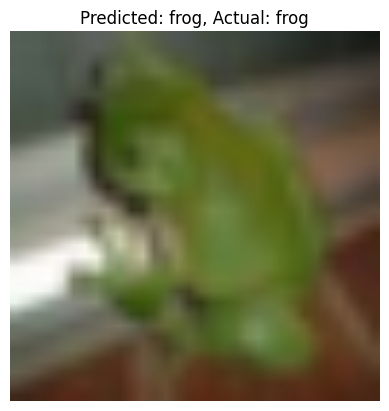

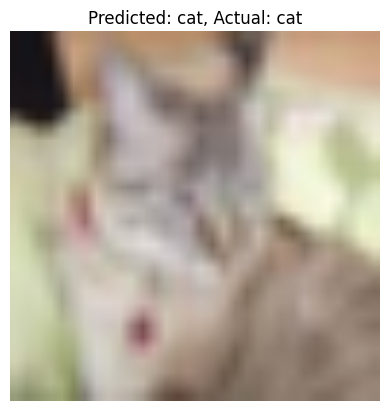

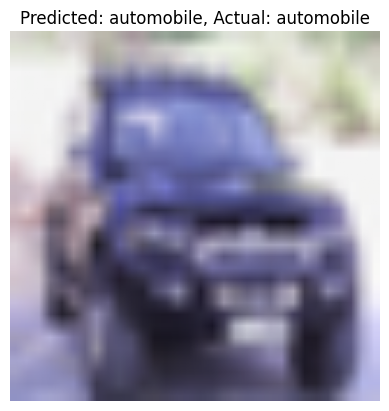

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Set the model to evaluation mode
model.eval()

# Transform to unnormalize images
unnormalize = transforms.Normalize((-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), (1.0 / 0.5, 1.0 / 0.5, 1.0 / 0.5))

# Iterate over the test dataset and make predictions
for data, labels in test_loader:
    data = data.to(device)

    # Forward pass
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)

    # Unnormalize and print images with predicted labels
    for i in range(10):
        image = unnormalize(data[i]).permute(1, 2, 0).cpu().numpy()
        plt.imshow(image)
        plt.title(f"Predicted: {classes[predicted[i].item()]}, Actual: {classes[labels[i].item()]}")
        plt.axis('off')
        plt.show()



    break  # Break after the first batch to visualize images


In [30]:
import torch
import timm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load the ViT model
model = timm.create_model('vit_small_patch16_224', pretrained=False)

# Count the number of parameters
num_params = count_parameters(model)
print("Number of parameters in ViT (vit_small_patch16_224):", num_params)


Number of parameters in ViT (vit_small_patch16_224): 22050664
